# validating tsinfer/tsdate tree sequence inference. 
## test 1: contemporaneous tips + recombination

This notebook is a continuation of mvr.ipynb. Previously, I perform topological inference (tsinfer) and internal node dating (tsdate) using the proxy method and varying parameters: recombination_rate AND mismatch_ratio. 

I will use variation of information criterion to understand how well tsinfer reconstructs recombination breakpoints (number and location). 

### import modules

In [1]:
import tsinfer
import tskit
import msprime
import tsdate
import numpy as np
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.linear_model import LinearRegression
from itertools import combinations
import seaborn as sns

### simulate ancestry
I use msprime to simulate a geneology of 25 individuals sampled contemporaneously at time = 0 with a fixed recombination rate. 

In [2]:
ts = msprime.sim_ancestry(
    samples = [
        msprime.SampleSet(25, time=0, ploidy = 1),
        #msprime.SampleSet(10, time=10, ploidy = 1),
        #msprime.SampleSet(5, time=50, ploidy = 1)
    ],
    ploidy = 1, 
    sequence_length=1e6,
    random_seed=50,
    recombination_rate=1e-6
)

### simulate mutations onto geneology 
I set a mutation rate onto the geneology. (Note: if I apply too low of a mutation rate, sampled genomes end up being too similar and tsinfer fails to reconstruct topology accurately.) 

In [3]:
ts = msprime.sim_mutations(ts, rate = 3e-5, random_seed = 42) 

The final simulated tree sequence contains 6 trees (i.e. 5 recombination breakpoints) and 256 mutations. 

In [4]:
ts

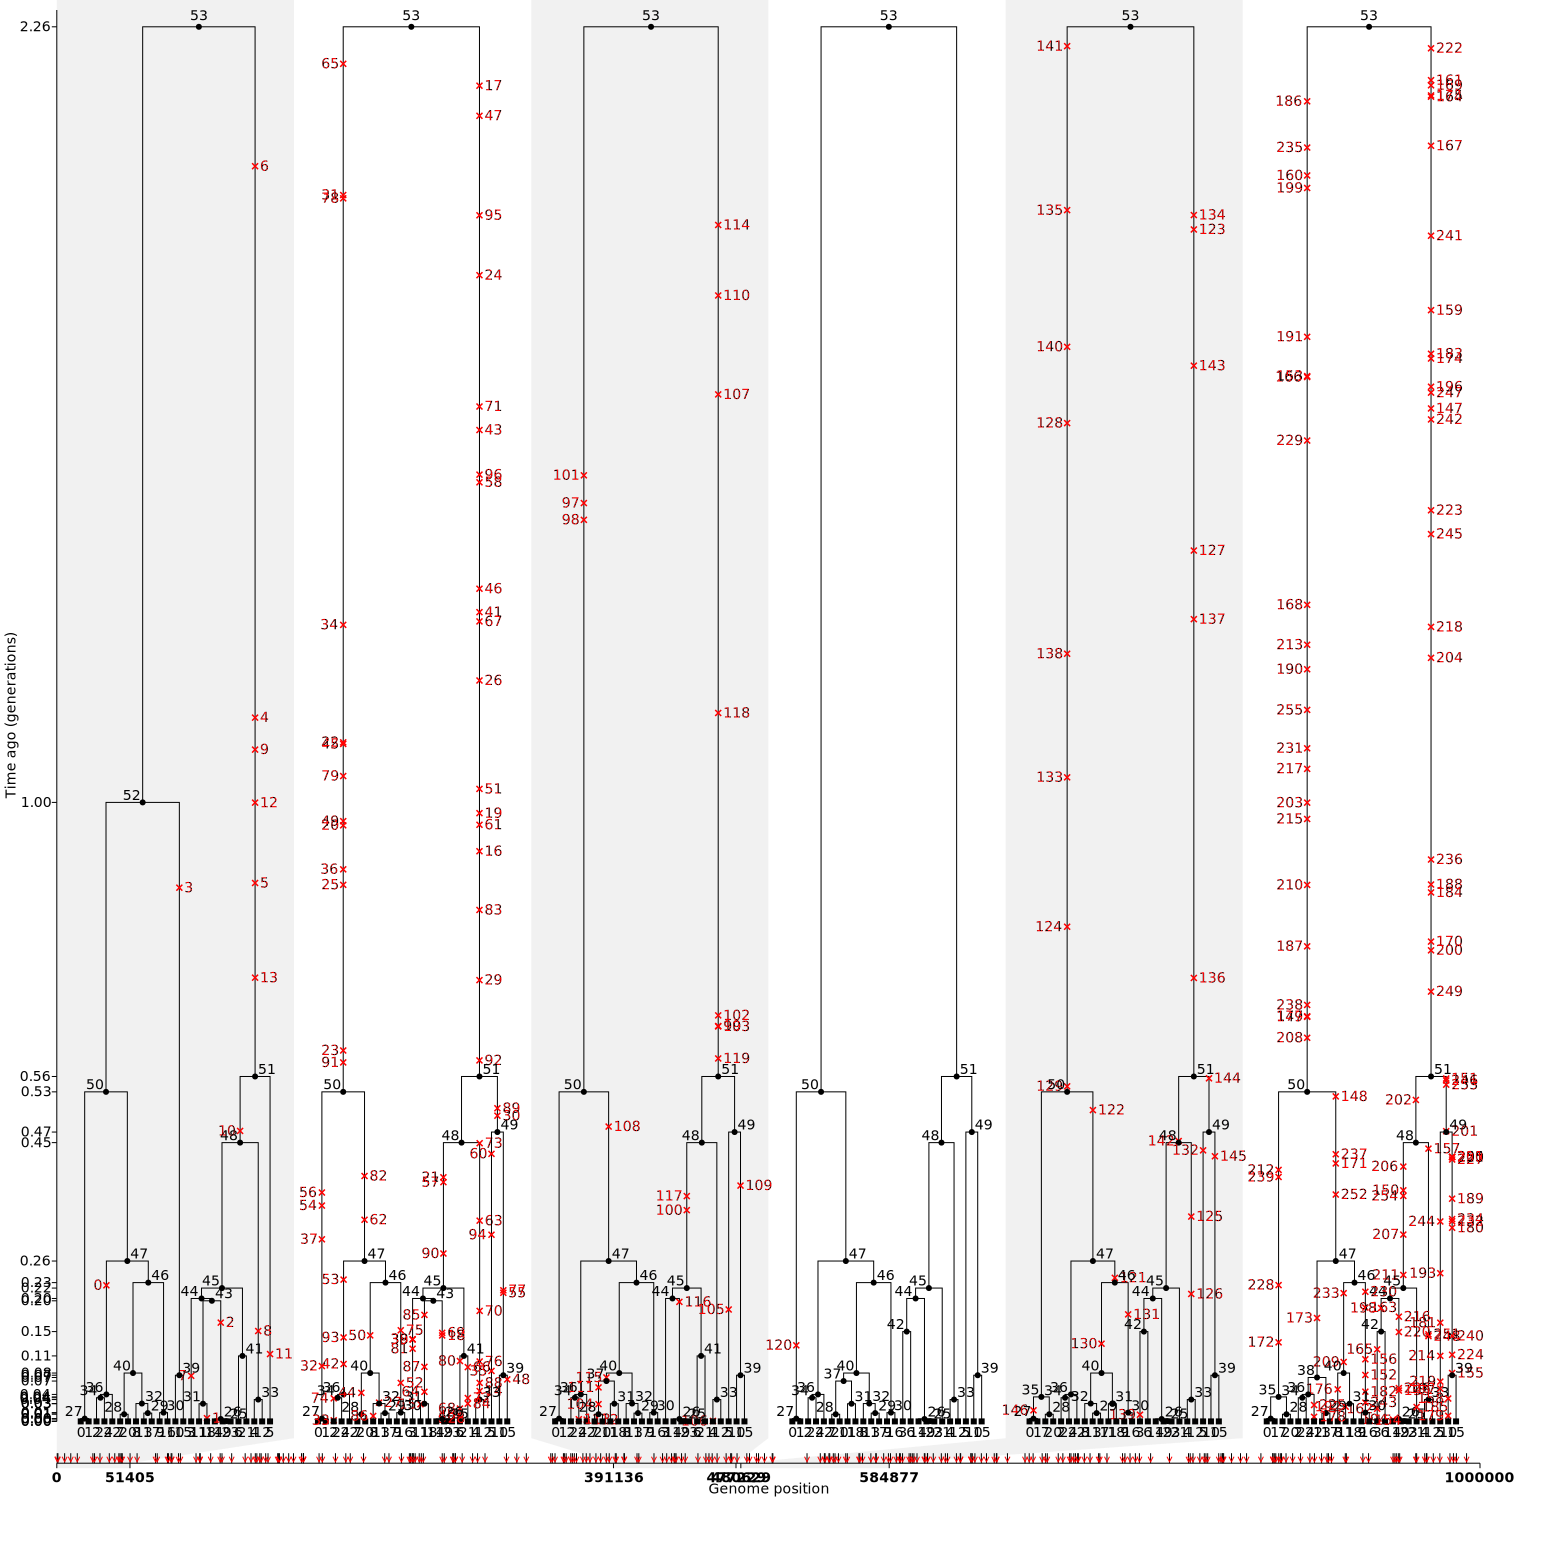

In [5]:
ts.draw_svg(size=(1500, 1500),
 canvas_size=(1550, 1550),
         y_axis=True
        )

### date internal nodes of simulated tree sequence

In [6]:
sampling_times = ts.nodes_time[0:25]

In [7]:
dated_ts = tsdate.date(ts, 
                       mutation_rate=3e-5, # same mutation rate used for simulation 
                       time_units="years", 
                       #return_fit=True,
                       match_segregating_sites = True
                       )



In [8]:
# integer value assigned to each individual in the tree. used for indexing purposes later on. 
samples = list(dated_ts.samples())

### export as vcf and import as vcz
Tsinfer can only read in VCZ files. I export the geneology as a VCF, translate to VCZ (bio2zarr), then reimport.

In [9]:
# with open(f"../../data/present_sim.vcf", "w") as fh: 
#     ts.write_vcf(output = fh)

In [10]:
# get ancestral states
ancestral_states = []

for site in ts.sites():
    if site.ancestral_state is None:
        ancestral_states.append("N")
        #print("N")
    else:
        ancestral_states.append(str(site.ancestral_state))
        #print(site.ancestral_state)

ancestral_states = np.array(ancestral_states)

Creating vdata object 

In [11]:
vdata = tsinfer.VariantData("../../data/vcz_files/present.vcz", 
                            ancestral_state=ancestral_states,
                           individuals_time=sampling_times)

## run inference
Reinfers the topological/temporal structure of the simulated tree sequences under varying rr (recombination rate) and mm (mismatch ratio). Called by rr_mm() and rr() functions. Returns rr and mm value used to produce tree sequence, as well as the dated simulated tree sequence. 

In [12]:
def run_inference2(vdata, rr_value = None, mm_value = None): 
    
    if rr_value != None:
        rr = rr_value 
        mm = mm_value
    else: 
        rr = None
        mm = None
        

    anc = tsinfer.generate_ancestors(vdata)
    anc_ts = tsinfer.match_ancestors(vdata, anc, recombination_rate = rr, mismatch_ratio = mm)
    ts = tsinfer.match_samples(vdata, anc_ts, recombination_rate = rr)
    simplified_ts = tsdate.preprocess_ts(ts, erase_flanks=False)

    dated_ts = tsdate.date(simplified_ts, 
                       mutation_rate=3e-5, 
                       time_units="years", 
                       #return_fit=True,
                       match_segregating_sites = True,
                       #rescaling_intervals = 492
                       )
    
    return rr, mm, dated_ts
     

### get tree width

In [13]:
def get_intervals(dated_ts): 

    data = []
    
    for tree in dated_ts.trees():
        left, right = tree.interval
        data.append({
            "tree_index": tree.index,
            "left": left,
            "right": right,
        })
    
    intervals = pd.DataFrame(data)

    return intervals


### get mrcas

Returns a dataframe of pairwise MRCAs for every combination of samples, for each tree within the simulated tree sequence.

In [14]:
def sims_times(dated_ts, samples):
    res = []

    for a, b in combinations(samples, 2):
        for i in range(0, dated_ts.get_num_trees()):
            t = dated_ts.at_index(i).tmrca(a, b)
            w = dated_ts.at_index(i).interval.right - dated_ts.at_index(i).interval.left
            l = dated_ts.at_index(i).interval.left
            r = dated_ts.at_index(i).interval.right
            res.append({"index": i, "sample_a": a, "sample_b": b, "mrca": t, "width": w, "left": l, "right": r})
            
    mrcas = pd.DataFrame(res) 
    return mrcas

Returns a dataframe of pairwise MRCAs for every combination of samples, for each tree within the inferred tree sequence.

In [15]:
def res_times(dated_ts, samples):
    res = []

    for a, b in combinations(samples, 2):
        for i in range(1, dated_ts.get_num_trees()-1): #flanking trees are not informative and must be trimmed
            t = dated_ts.at_index(i).tmrca(a, b)
            w = dated_ts.at_index(i).interval.right - dated_ts.at_index(i).interval.left
            l = dated_ts.at_index(i).interval.left
            r = dated_ts.at_index(i).interval.right
            res.append({"index": i, "sample_a": a, "sample_b": b, "mrca": t, "width": w, "left": l, "right": r})
            
    mrcas = pd.DataFrame(res) 
    return mrcas

In [16]:
# def lg(mrcas):
#     X = mrcas["proxy"].values.reshape(-1, 1)
#     y = mrcas["sim"].values
#     weights = mrcas["width"]/1e6
#     reg = LinearRegression().fit(X, y, weights)
#     return X, y, reg, weights


### varying recombination rate and mismatch_ratio during inference

Produces an array of recombination rates and mismatch ratios , then calls run_inference to infer tree sequences under varying parameters. Returns counts (for indexing), metadata (tree index, rr and mm values), and seqs(a list of tree sequences). 

In [17]:
def rr_mm(vdata): 
    
    rates = [10**x for x in range(-8, 0, 1)]
    rates.append(None)

    mms = [10**x for x in range(-3, 1, 1)]
    #mms.append(None) 
    
    grid_num_trees = np.zeros(shape=(11, 4))
    seqs = [] #save each ts here 
    
    count = 0
    nones = 0

    metadata = [] 
    counts = []
    for rr_idx, rr_value in enumerate(rates):
        for mm_idx, mm_value in enumerate(mms): 

            if nones > 0: 
                break

            if rr_value == None:
                mm_value = 1
                nones += 1 
            
            count+=1
            
            rr, mm, ip = run_inference2(vdata, rr_value, mm_value)
            
            grid_num_trees[rr_idx][mm_idx] = ip.num_trees
            
            seqs.append(ip) 

            metadata.append({"index": count-1, "rate": rr, "mm": mm})

            counts.append({"rate": rr, "mm": mm, "num_trees": ip.num_trees}) 

            print(f"Finished inference {count}/{len(rates)}. RR: {rr_value}, MM: {mm_value}, num trees: {ip.num_trees}")

    return pd.DataFrame(counts), pd.DataFrame(metadata), seqs 


### run inference

Here, I run rr_mm which produces N tree sequences with varying numbers of recombination breakpoints. 

In [18]:
counts, metadata, seqs = rr_mm(vdata)

Finished inference 1/9. RR: 1e-08, MM: 0.001, num trees: 11
Finished inference 2/9. RR: 1e-08, MM: 0.01, num trees: 11
Finished inference 3/9. RR: 1e-08, MM: 0.1, num trees: 11
Finished inference 4/9. RR: 1e-08, MM: 1, num trees: 8
Finished inference 5/9. RR: 1e-07, MM: 0.001, num trees: 11
Finished inference 6/9. RR: 1e-07, MM: 0.01, num trees: 11
Finished inference 7/9. RR: 1e-07, MM: 0.1, num trees: 11
Finished inference 8/9. RR: 1e-07, MM: 1, num trees: 8
Finished inference 9/9. RR: 1e-06, MM: 0.001, num trees: 11
Finished inference 10/9. RR: 1e-06, MM: 0.01, num trees: 11
Finished inference 11/9. RR: 1e-06, MM: 0.1, num trees: 11
Finished inference 12/9. RR: 1e-06, MM: 1, num trees: 8
Finished inference 13/9. RR: 1e-05, MM: 0.001, num trees: 11
Finished inference 14/9. RR: 1e-05, MM: 0.01, num trees: 11
Finished inference 15/9. RR: 1e-05, MM: 0.1, num trees: 11
Finished inference 16/9. RR: 1e-05, MM: 1, num trees: 8
Finished inference 17/9. RR: 0.0001, MM: 0.001, num trees: 12
Fin

#### get mrca dfs for simulated tree

In [19]:
rates = [10**x for x in range(-8, 0, 1)]
rates.append("None")

In [20]:
sim_list = sims_times(dated_ts, samples) 

#### get mrca dfs for each tree (w/ varying mm)

In [21]:
rates = [10**x for x in range(-8, 0, 1)]
rates.append("None")

In [22]:
mms = [10**x for x in range(-3, 1, 1)]
#mms.append(None)

In [23]:
res_list = []

for id, ts in enumerate(seqs): 
    df = res_times(ts, samples)
    df['rr'] = str(metadata[metadata.index==id].rate.iloc[0]) ###  
    df['mm'] = str(metadata[metadata.index==id].mm.iloc[0]) #### 
    res_list.append(df) 

# Analysis

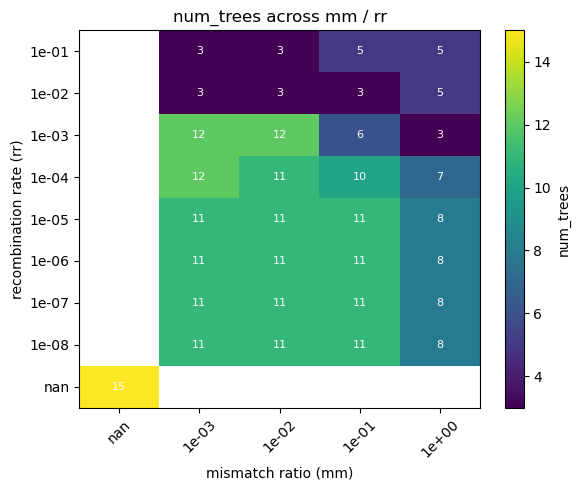

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = counts.copy()

# replace NAs with string
df["rr"] = df["rate"].astype(float)
df["mm"] = df["mm"].apply(lambda x: "nan" if pd.isna(x) else float(x))

# rows = rr (Y), columns = mm (X)
pivot_trees = df.pivot(index="rr", columns="mm", values="num_trees")

# sort axes so NAs are first 
cols = pivot_trees.columns.tolist()
cols_sorted = ["nan"] if "nan" in cols else []
cols_sorted += sorted([c for c in cols if c != "nan"], key=lambda x: float(x))
pivot_trees = pivot_trees[cols_sorted]
pivot_trees = pivot_trees.sort_index(ascending=False)

# plot heatmap
plt.figure(figsize=(6, 5))
im = plt.imshow(pivot_trees.values, aspect='auto', cmap='viridis')

# annotate cells with num_trees
for i in range(pivot_trees.shape[0]):
    for j in range(pivot_trees.shape[1]):
        val = pivot_trees.iloc[i, j]
        if not np.isnan(val):
            plt.text(j, i, int(val), ha='center', va='center', color='white', fontsize=8)

# colorbar and ticks
plt.colorbar(im, label='num_trees')
plt.xticks(
    range(len(pivot_trees.columns)),
    [str(c) if c == "nan" else f"{float(c):.0e}" for c in pivot_trees.columns],
    rotation=45
)
plt.yticks(
    range(len(pivot_trees.index)),
    [f"{float(y):.0e}" for y in pivot_trees.index]
)

# labeling
plt.xlabel('mismatch ratio (mm)')
plt.ylabel('recombination rate (rr)')
plt.title('num_trees across mm / rr')
plt.tight_layout()
plt.show()


# variation of information criterion

In [33]:
# counts : [index] rate mm num_trees
# metadata : index rate mm

In [28]:
sim_df

,index,sample_a,sample_b,mrca,width,left,right
0,0,0,1,0.003397,51405.0,0.0,51405.0
1,1,0,1,0.003397,339731.0,51405.0,391136.0
2,2,0,1,0.003397,86093.0,391136.0,477229.0
3,3,0,1,0.003397,3400.0,477229.0,480629.0
4,4,0,1,0.003397,104248.0,480629.0,584877.0
...,...,...,...,...,...,...,...
1795,1,23,24,2.379799,339731.0,51405.0,391136.0
1796,2,23,24,2.379799,86093.0,391136.0,477229.0
1797,3,23,24,2.379799,3400.0,477229.0,480629.0
1798,4,23,24,2.379799,104248.0,480629.0,584877.0


### get segments

In [43]:
def get_segments(df): 
    seg = (sim_list.drop_duplicates('index').sort_values('left')[['left','right']].to_numpy(float))
    return seg

In [50]:
# segments for simulated tree sequence
get_segments(sim_list)

array([[      0.,   51405.],
       [  51405.,  391136.],
       [ 391136.,  477229.],
       [ 477229.,  480629.],
       [ 480629.,  584877.],
       [ 584877., 1000000.]])

In [ ]:
# segments for inferred tree sequence 0/32 
get_segments(res_list[0])

### get coordinates 

In [46]:
def get_coordinates(seg):
    bps = seg[:-1, 1]  # right edges except the last
    bps = np.concatenate(([seg[0,0]], bps, [seg[-1,1]]))
    return bps

In [49]:
get_coordinates(get_segments(sim_list))

array([      0.,   51405.,  391136.,  477229.,  480629.,  584877.,
       1000000.])

### VI segments

### VI breakpoints